In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
from numba import jit

## Stimulus generation (cf. Figure 1B and 1D of Bhattacharyya et. al 2017)

In [2]:
def generate_stimulus(stim_size=1, speed=1, length=10, dt=0.1, init_distance=50):
    timesteps = np.arange(int(length/dt))*dt
    distances = init_distance - timesteps*speed
    angles = np.arctan2(stim_size/2, distances)*2
    angles_degrees = angles/np.pi*180
    return timesteps, angles_degrees, distances

[ 131.57894737   65.78947368   44.64285714   33.78378378   26.88172043
   22.52252252]


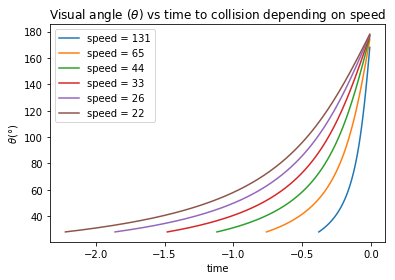

In [3]:
# these values are taken from Bhattacharyya et. al 2017:
LV_vals = np.array([0.19, 0.38, 0.56, 0.74, 0.93, 1.11])
stim_size = 25
speeds = 1/(LV_vals/stim_size)
print(speeds)

#plt.figure(figsize=(8,8))
for speed in speeds:
    t, stims, dists = generate_stimulus(stim_size=stim_size, speed=speed, dt=0.01)
    collision_idx = np.argmin(np.abs(dists))
    t_collision = t[collision_idx]
    stim_collision = stims[collision_idx]
    
    before_collision_mask = t<t_collision
    t_to_collision = t[before_collision_mask] - t_collision
    stim_to_collision = stims[before_collision_mask]
    plt.plot(t_to_collision, stim_to_collision, label='speed = ' + str(int(speed)))
plt.xlabel('time')
plt.ylabel(r'$\theta (\degree)$')
plt.title(r'Visual angle ($\theta$) vs time to collision depending on speed')
plt.legend()
#print(dists)

## Linear function of visual angle

In [4]:
def f_theta_linear(theta, m, b):
    return theta*m + b

def transform_stim(stim_size, speed, length, dt, m=1.5, b=0):
    t, stims, dists = generate_stimulus(stim_size=stim_size, speed=speed, length=length, dt=dt)
    collision_idx = np.argmin(np.abs(dists))
    t_collision = t[collision_idx]
    stim_collision = stims[collision_idx]
    before_collision_mask = t<t_collision
    t_to_collision = t[before_collision_mask] - t_collision
    stim_to_collision = stims[before_collision_mask]
    transformed_stim_to_collision = f_theta_linear(stim_to_collision, m=m, b=b)
    transformed_stims = f_theta_linear(stims, m=m, b=b)
    return t, stims, transformed_stims, dists, t_to_collision, transformed_stim_to_collision

## Leaky Integrate-and-Fire model of the Mauthner cell (adopted from Koyama et. al 2016)

In [27]:
def lif_dynamics(tau_m, e_l, r_m, stimulus, noise, v_t, dt, total_time, init_vm_std):
    ntime_steps = int(total_time/dt)
    time_points = np.arange(ntime_steps)*dt
    v_m = np.zeros(ntime_steps)
    v_m[0] = np.random.normal(loc=e_l, scale=init_vm_std)
    t_spks = []
    idx_spks = []
    # integration:
    t = 1
    while t < ntime_steps:
        v_m[t] = v_m[t - 1] + dt*(- (v_m[t - 1] - e_l) + r_m*stimulus[t])/tau_m + noise[t]
        if v_m[t] > v_t:
            v_m[t] = e_l
            t_spks.append(t*dt)
            idx_spks.append(t)
        t = t + 1

    return time_points, v_m, t_spks, idx_spks

In [28]:
@jit
def jit_lif_dynamics(tau_m, e_l, r_m, stimulus, noise, v_t, dt, total_time, init_vm_std):
    ntime_steps = int(total_time/dt)
    time_points = np.arange(ntime_steps)*dt
    v_m = np.zeros(ntime_steps)
    v_m[0] = np.random.normal(loc=e_l, scale=init_vm_std)
    t_spks = []
    idx_spks = []
    # integration:
    t = 1
    while t < ntime_steps:
        v_m[t] = v_m[t - 1] + dt*(- (v_m[t - 1] - e_l) + r_m*stimulus[t])/tau_m + noise[t]
        if v_m[t] > v_t:
            v_m[t] = e_l
            t_spks.append(t*dt)
            idx_spks.append(t)
        t = t + 1

    return time_points, v_m, t_spks, idx_spks

In [29]:
tau_m = 0.023
e_l = -0.079
r_m = 10*1e6 # MOhm
v_t = -0.061
init_vm_std = 0.005

dt = 0.0001
total_time = 1

noise_std = 5*1e-3
n_timepoints = int(total_time/dt)

stimulus = np.arange(n_timepoints)*1e-11
sigma = noise_std * np.sqrt(dt)
print(sigma)
noise_vals = np.random.normal(loc=0.0, scale=sigma, size=n_timepoints)
#stimulus = noise_vals + stimulus

#np.random.seed(1)
time, v_m, spks, spk_idc = lif_dynamics(tau_m, e_l, r_m, stimulus, noise_vals, v_t, dt, total_time, init_vm_std)

5e-05


In [31]:
%timeit lif_dynamics(tau_m, e_l, r_m, stimulus, noise_vals, v_t, dt, total_time, init_vm_std)

15.1 ms ± 623 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
%timeit jit_lif_dynamics(tau_m, e_l, r_m, stimulus, noise_vals, v_t, dt, total_time, init_vm_std)

186 µs ± 5.12 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [35]:
def calc_response(params):
    lv = np.random.rand()*1.1 + 0.1
    stim_size = np.random.rand()*15 + 10
    speed = 1/(lv/stim_size)
    t, stims, tstims, dists, t_to_coll, tstim_to_coll = transform_stim(stim_size, speed, params['total_time'],
                                                                       params['dt'], params['m'], params['b'])

    stimulus = tstims*1e-11
    sigma = params['noise_std'] * np.sqrt(params['dt'])
    noise_vals = np.random.normal(loc=0.0, scale=sigma, size=len(stimulus))

    #np.random.seed(1)
    time, v_m, spks, spk_idc = jit_lif_dynamics(params['tau_m'], params['e_l'], params['r_m'], stimulus, noise_vals,
                                                params['v_t'], params['dt'], params['total_time'], params['init_vm_std'])
    if not len(spks)==0:
        first_spike = spks[0]
        first_spike_idx = spk_idc[0]
    else:
        first_spike = 0
        first_spike_idx = 0
    if not first_spike_idx >= len(t_to_coll):
        resp_in_t_to_coll = t_to_coll[first_spike_idx]
    else:
        resp_in_t_to_coll = 0
    return stims[first_spike_idx], dists[first_spike_idx], first_spike, lv, stim_size, speed, resp_in_t_to_coll

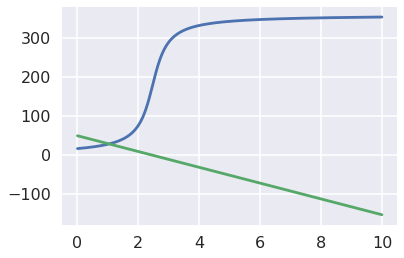

In [36]:
LV_vals = np.array([0.19, 0.38, 0.56, 0.74, 0.93, 1.11])
stim_size = 15
length = 10
dt = 0.01
m = 1.5
b = 0
speeds = 1/(LV_vals/stim_size)
speed = speeds[3]
t, stims, tstims, dists, t_to_collision, transformed_stim_to_collision = transform_stim(stim_size, speed, length, dt, m, b)
plt.plot(t, stims)
plt.plot(t, dists)

In [83]:
tau_m = 0.023
e_l = -0.079
r_m = 10*1e6 # MOhm
v_t = -0.061
init_vm_std = 0.005

dt = 0.001
total_time = 5

noise_std = 20*1e-3
n_timepoints = int(total_time/dt)

# generate looming stimulus
LV_vals = np.array([0.19, 0.38, 0.56, 0.74, 0.93, 1.11])
stim_size = 10
speeds = 1/(LV_vals/stim_size)
speed = speeds[2]

m = 5.5
b = 0

t, stims, tstims, dists, t_to_collision, transformed_stim_to_collision = transform_stim(stim_size, speed, total_time, dt, m, b)

stimulus = tstims*1e-11
sigma = noise_std * np.sqrt(dt)
#print(sigma)
noise_vals = np.random.normal(loc=0.0, scale=sigma, size=n_timepoints)
#stimulus = noise_vals + stimulus

#np.random.seed(1)
time, v_m, spks, spk_idc = jit_lif_dynamics(tau_m, e_l, r_m, stimulus, noise_vals, v_t, dt, total_time, init_vm_std)
first_spike = spks[0]
first_spike_idx = spk_idc[0]

Response angle at first spike: 26.3528375057 degree
Distance at first spike: 21.3571428571 mm


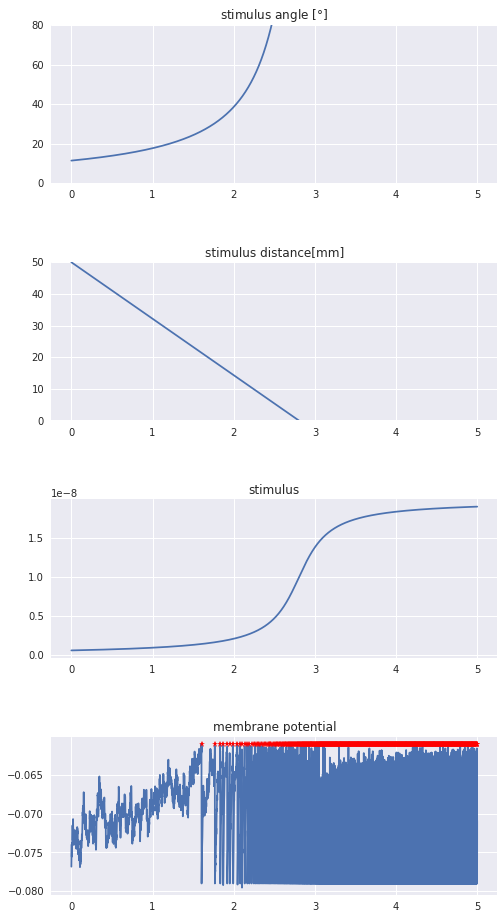

In [84]:
fig, axes = plt.subplots(4, 1, figsize=(8,16))
axes[0].plot(time, stims)
axes[0].set_title(r'stimulus angle [$ \degree $]')
axes[0].set_ylim([0, 80])
axes[1].plot(time, dists)
axes[1].set_title('stimulus distance[mm]')
axes[1].set_ylim([0, 50])
axes[2].plot(time, stimulus)
axes[2].set_title('stimulus')
axes[3].plot(time, v_m)
axes[3].set_title('membrane potential')
if not len(spks) == 0:
    axes[3].plot(spks, np.ones(len(spks))*v_t, 'r*')
plt.subplots_adjust(hspace=0.5)
print('Response angle at first spike: ' + str(stims[first_spike_idx]) + ' degree')
print('Distance at first spike: ' + str(dists[first_spike_idx]) + ' mm')

## One parameter set example

Mean visual angle: 51.5013764669
Mean distance: 18.6765112742
Mean reaction time: 1.302172
resp in ttc: -0.643


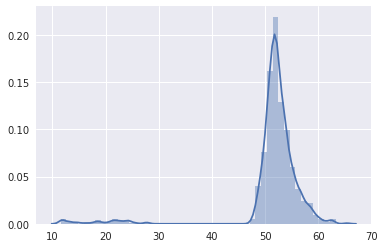

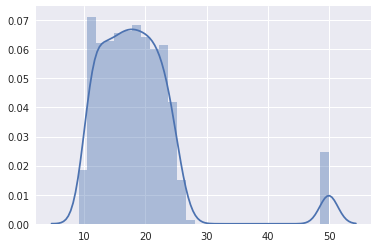

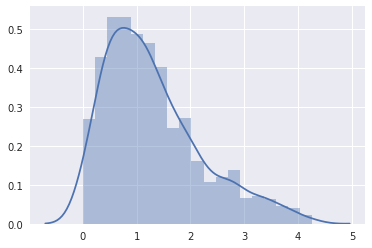

In [78]:
# generate looming stimulus
LV_vals = np.array([0.19, 0.38, 0.56, 0.74, 0.93, 1.11])
stim_size = 10
speeds = 1/(LV_vals/stim_size)
speed = speeds[1]

params = {'tau_m': 0.023,
          'e_l': -0.079,
          'r_m': 10*1e6,
          'v_t': -0.061,
          'init_vm_std': 0.010,
          'dt': 0.001,
          'total_time': 5,
          'noise_std': 5*1e-3,
          'n_timepoints': int(total_time/dt),
          'm': 3.5,
          'b': 0}

nruns = 1000
rstims = np.zeros(nruns)
rdists = np.zeros(nruns)
reaction_times = np.zeros(nruns)
for i in np.arange(nruns):
    rstims[i], rdists[i], reaction_times[i], lv, stim_size, speed, resp_in_t_to_coll = calc_response(params)

sns.set()
sns.distplot(rstims)
print('Mean visual angle: ' + str(np.mean(rstims)))
plt.figure()
sns.distplot(rdists)
print('Mean distance: ' + str(np.mean(rdists)))
plt.figure()
sns.distplot(reaction_times)
print('Mean reaction time: ' + str(np.mean(reaction_times)))
print('resp in ttc: ' + str(resp_in_t_to_coll))

## Analyzing the influence of m, b and noise

In [101]:
params = {'tau_m': 0.023,
          'e_l': -0.079,
          'r_m': 10*1e6, # MOhm
          'v_t': -0.061,
          'init_vm_std': 0.001,
          'dt': 0.001,
          'total_time': 5,
          'noise_std': 5*1e-3,
          'n_timepoints': int(total_time/dt),
          'm': 4.5,
          'b': 5}

mvals = np.array([1, 2, 4, 6])
nmvals = len(mvals)
noisevals = np.array([1, 10, 20])*1e-3
nruns = 250
data_cols = ['resp_angle', 'resp_dist', 'resp_time', 'lv', 'stim_size', 'speed', 'm', 'noise', 'resp_time_coll']
data_dict = dict([(col_name, []) for col_name in data_cols])

for noise_idx, noise in enumerate(noisevals):
    params['noise_std'] = noise
    for m_idx, mval in enumerate(mvals):
        params['m'] = mval
        for i in np.arange(nruns):
            resp_angle, resp_dist, resp_time, lv, stim_size, speed, resp_time_coll = calc_response(params)
            resp_angle = np.round(resp_angle, decimals=1)
            resp_dist = np.round(resp_dist, decimals=1)
            resp_time = np.round(resp_time, decimals=3)
            lv = np.round(lv, decimals=2)
            stim_size = np.round(stim_size, decimals=1)
            speed = np.round(speed, decimals=1)
            resp_time_coll = np.round(resp_time_coll, decimals=3)
            result_values = [resp_angle, resp_dist, resp_time, lv, stim_size, speed, mval, noise, resp_time_coll]
            for col, value in zip(data_cols, result_values):
                data_dict[col].append(value)

In [102]:
df = pd.DataFrame(data_dict)

In [103]:
df.describe()

,lv,m,noise,resp_angle,resp_dist,resp_time,resp_time_coll,speed,stim_size
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.646463,3.250000,0.010333,82.651367,17.262467,1.300957,-0.663931,39.470000,17.502900
std,0.316190,1.920607,0.007762,58.781545,14.567794,1.002110,0.690704,33.471459,4.332167
min,0.100000,1.000000,0.001000,11.600000,-6.200000,0.000000,-4.999000,8.700000,10.000000
25%,0.380000,1.750000,0.001000,31.400000,4.800000,0.502750,-1.046000,18.900000,13.700000
50%,0.650000,3.000000,0.010000,50.600000,14.450000,1.066500,-0.446000,27.500000,17.500000
75%,0.920000,4.500000,0.020000,112.125000,28.000000,1.866000,-0.097750,45.800000,21.300000
max,1.200000,6.000000,0.020000,237.700000,50.000000,4.984000,0.000000,231.700000,25.000000


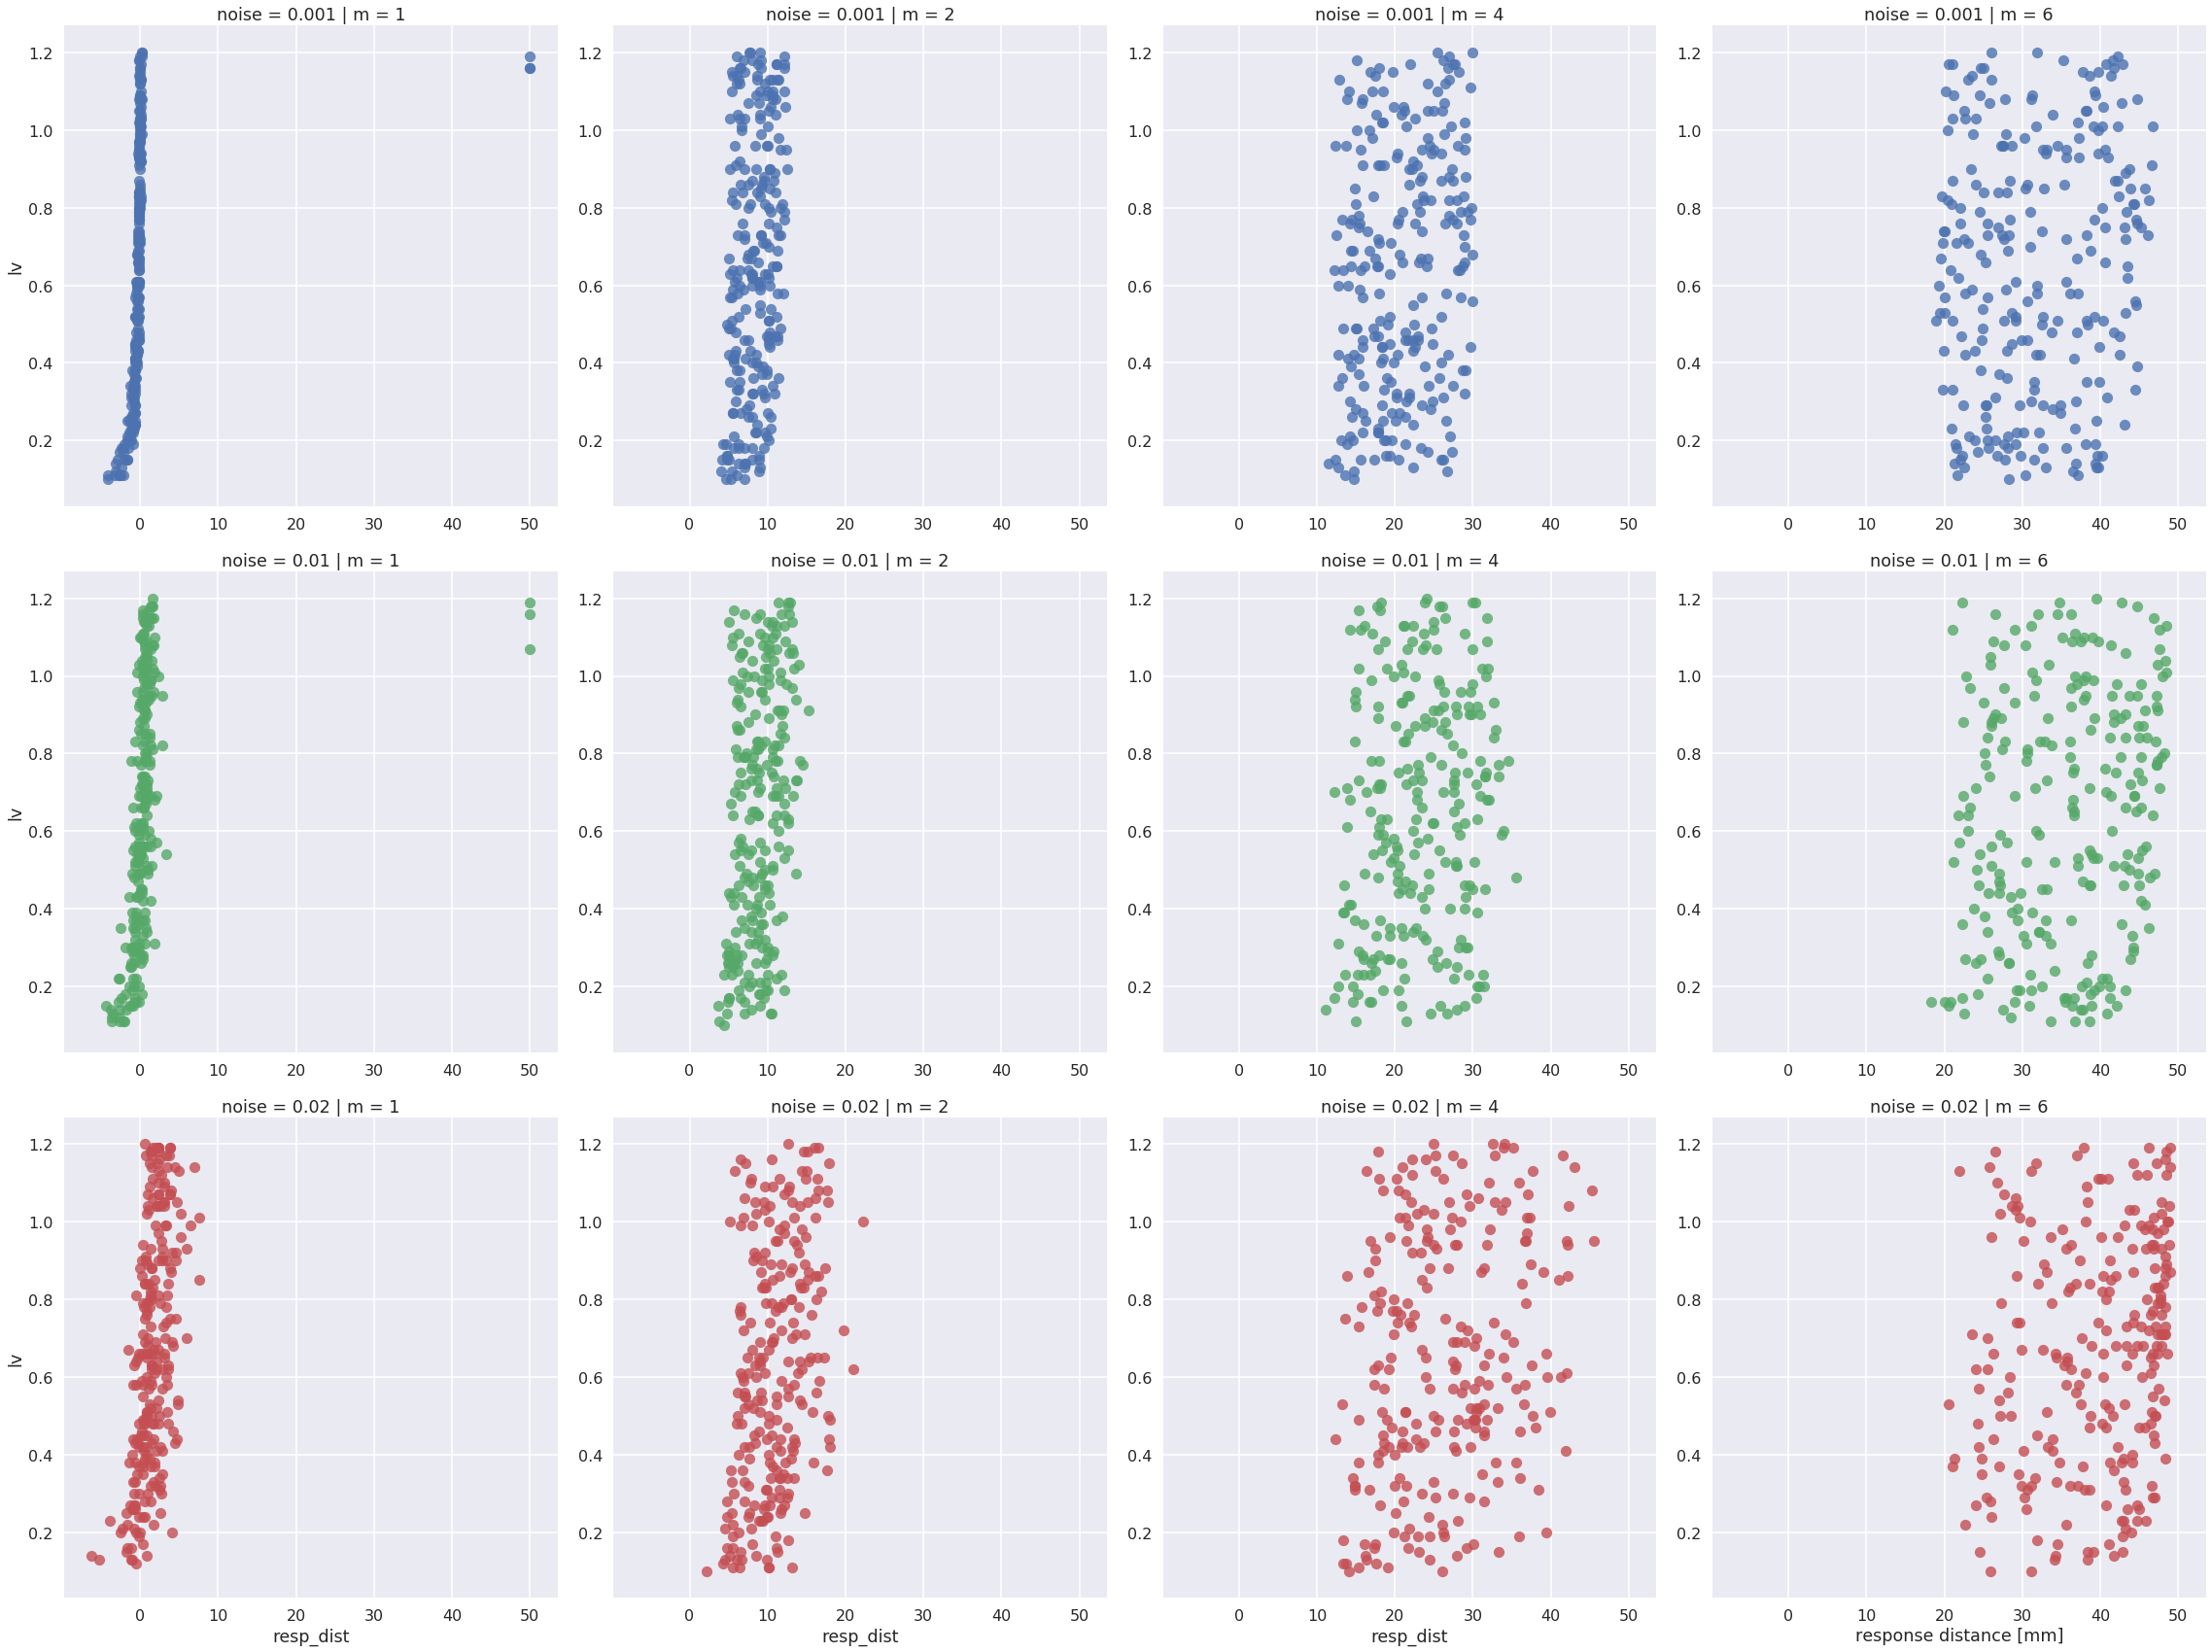

In [104]:
sns.set('poster')
g = sns.lmplot(x='resp_dist', y='lv', col='m', row='noise', hue='noise', data=df, fit_reg=False, size=8)
plt.xlabel('response distance [mm]')
g.savefig('rand_init_resp_dist_vs_speed_b=5.pdf')

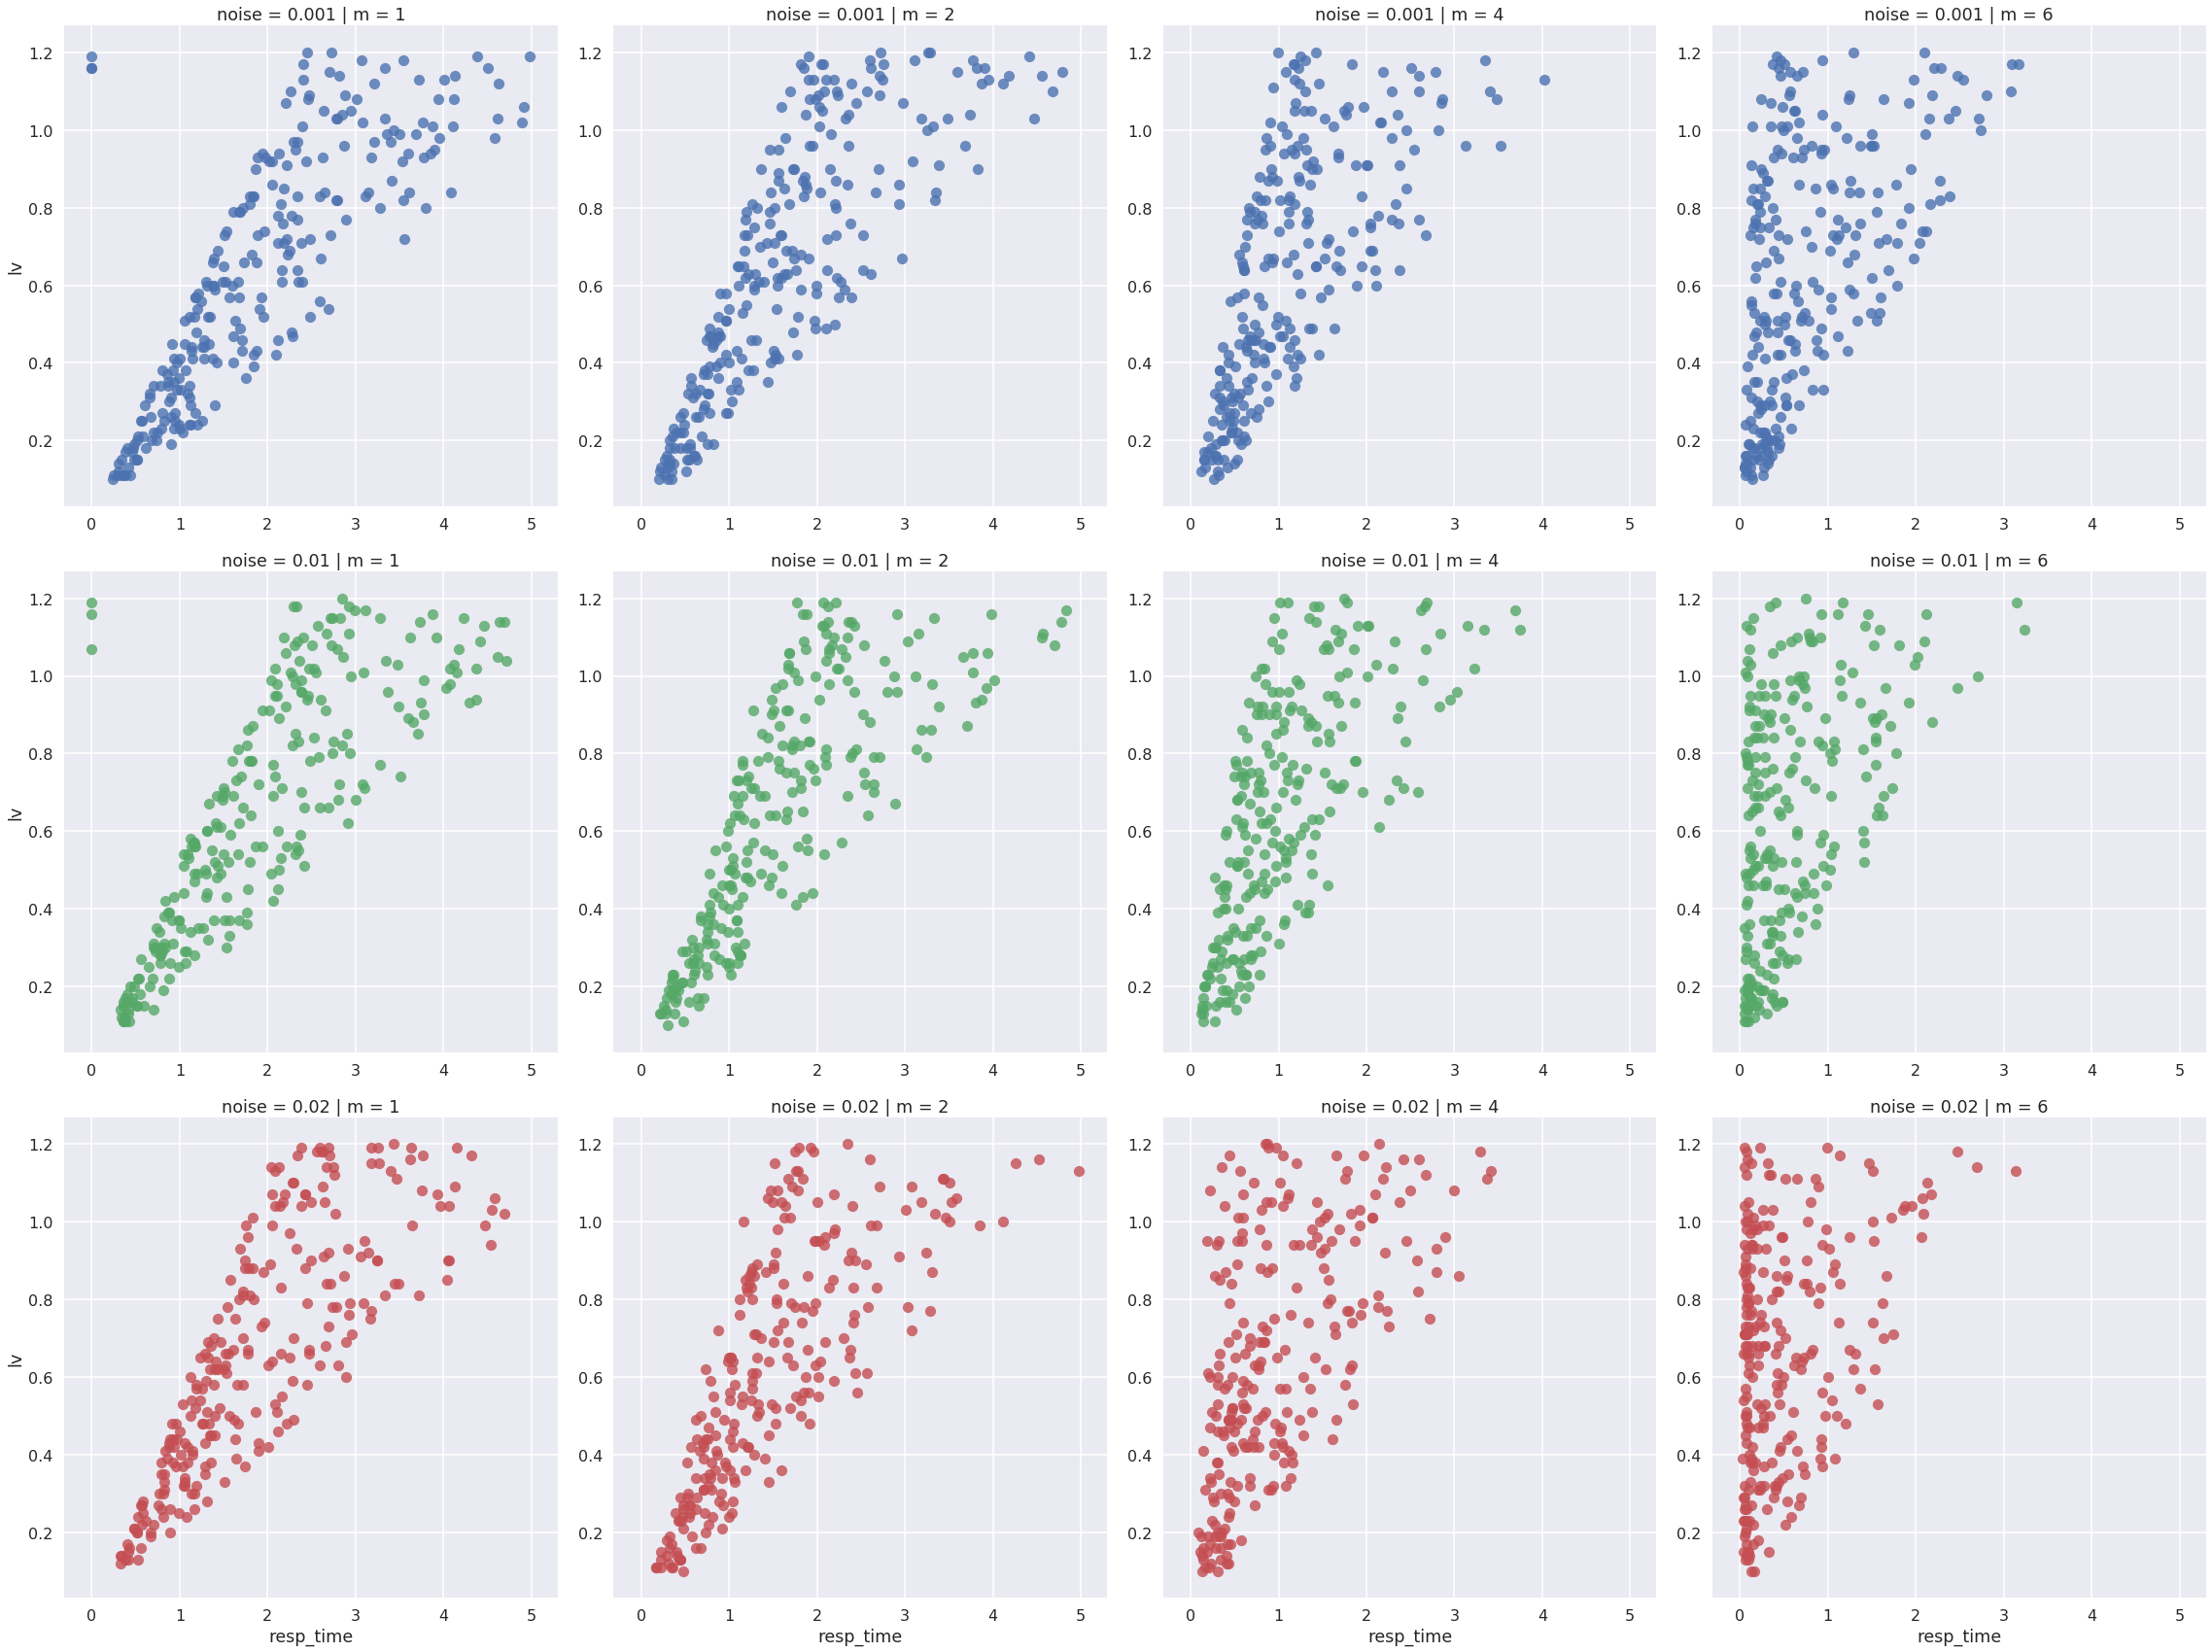

In [105]:
sns.set('poster')
g = sns.lmplot(x='resp_time', y='lv', col='m', row='noise', hue='noise', data=df, fit_reg=False, size=8)
g.savefig('rand_init_resp_time_vs_speed_b=5.pdf')

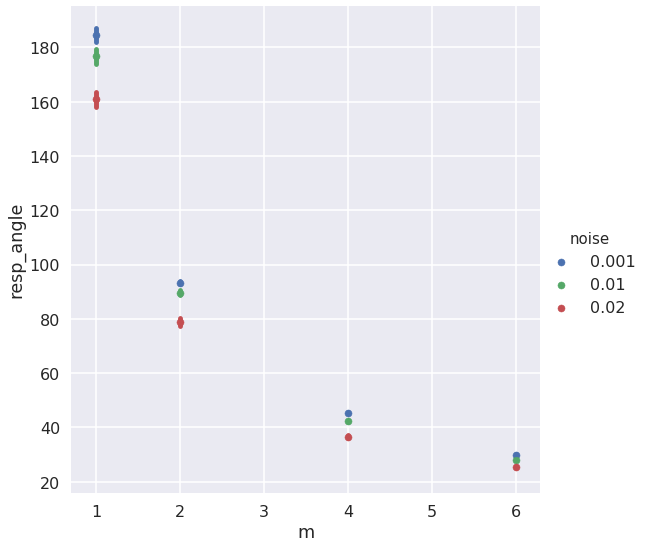

In [106]:
sns.set('poster')
g = sns.lmplot(x='m', y='resp_angle', hue='noise', data=df, fit_reg=False, size=8, x_estimator=np.mean)
g.savefig('rand_init_resp_angle_vs_m_b=5.pdf')

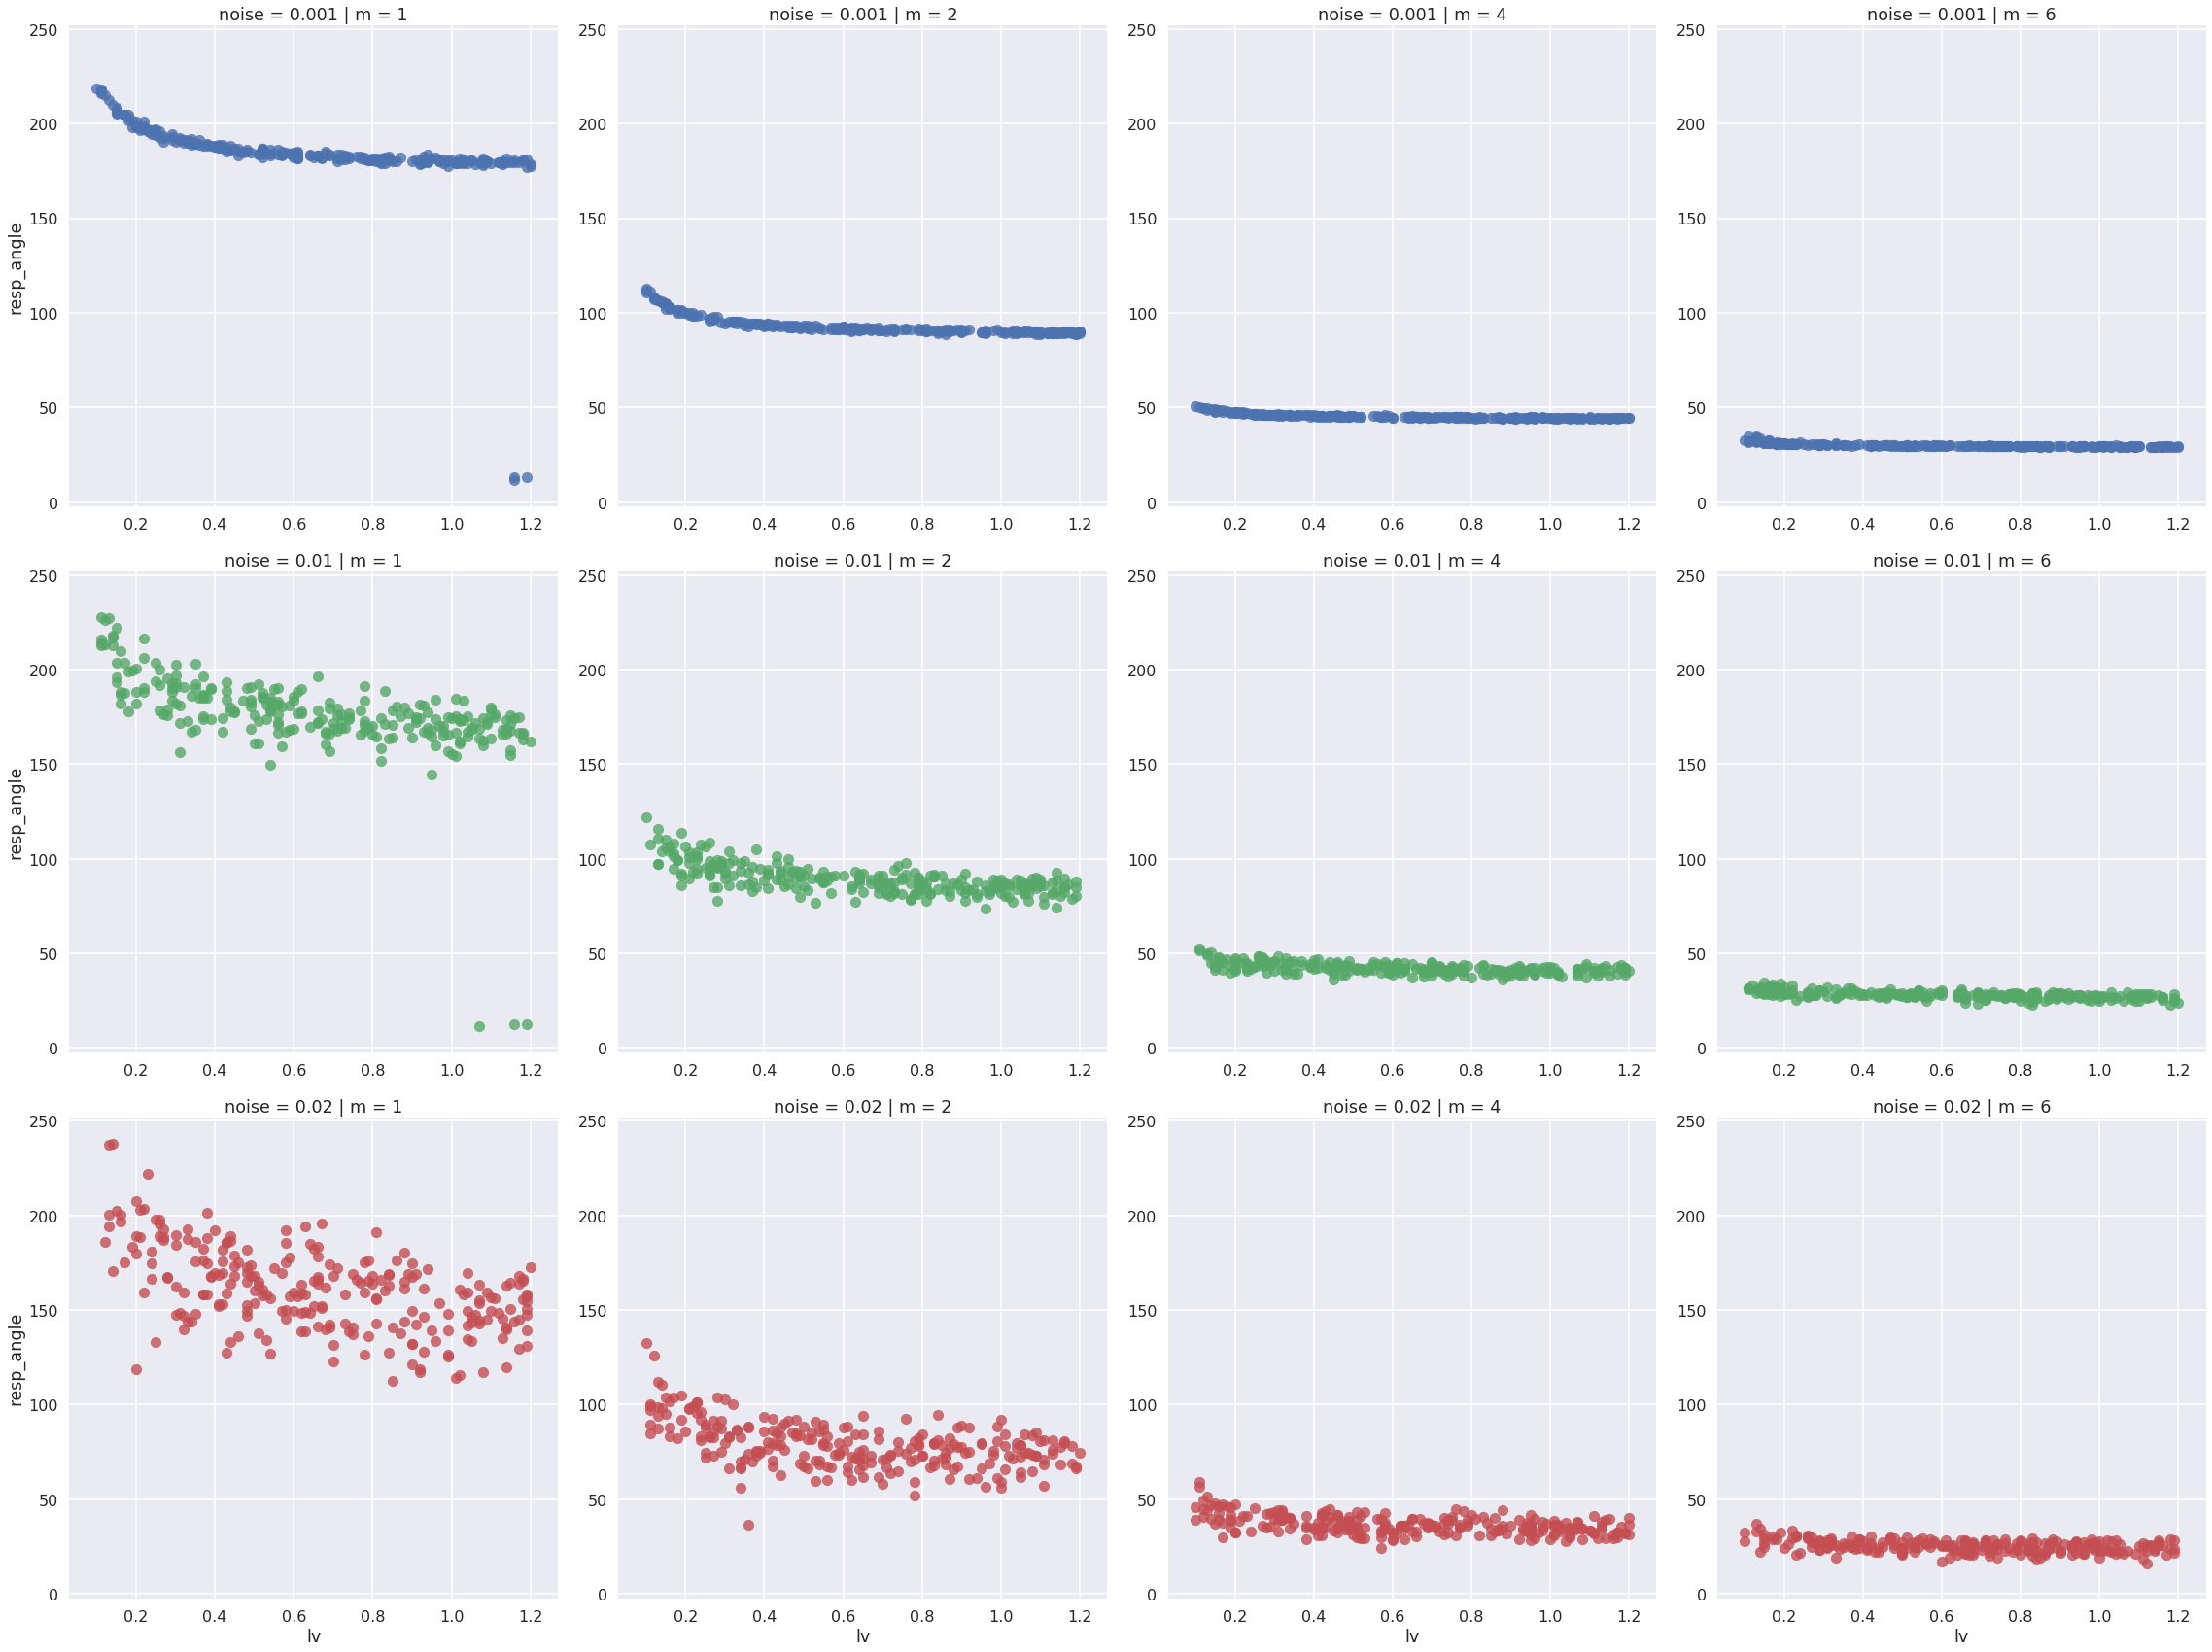

In [107]:
#sns.set('poster')
g = sns.lmplot(x='lv', y='resp_angle', hue='noise', row='noise', col='m', data=df, fit_reg=False, size=8)
g.savefig('rand_init_resp_angle_vs_lv_b=5.pdf')

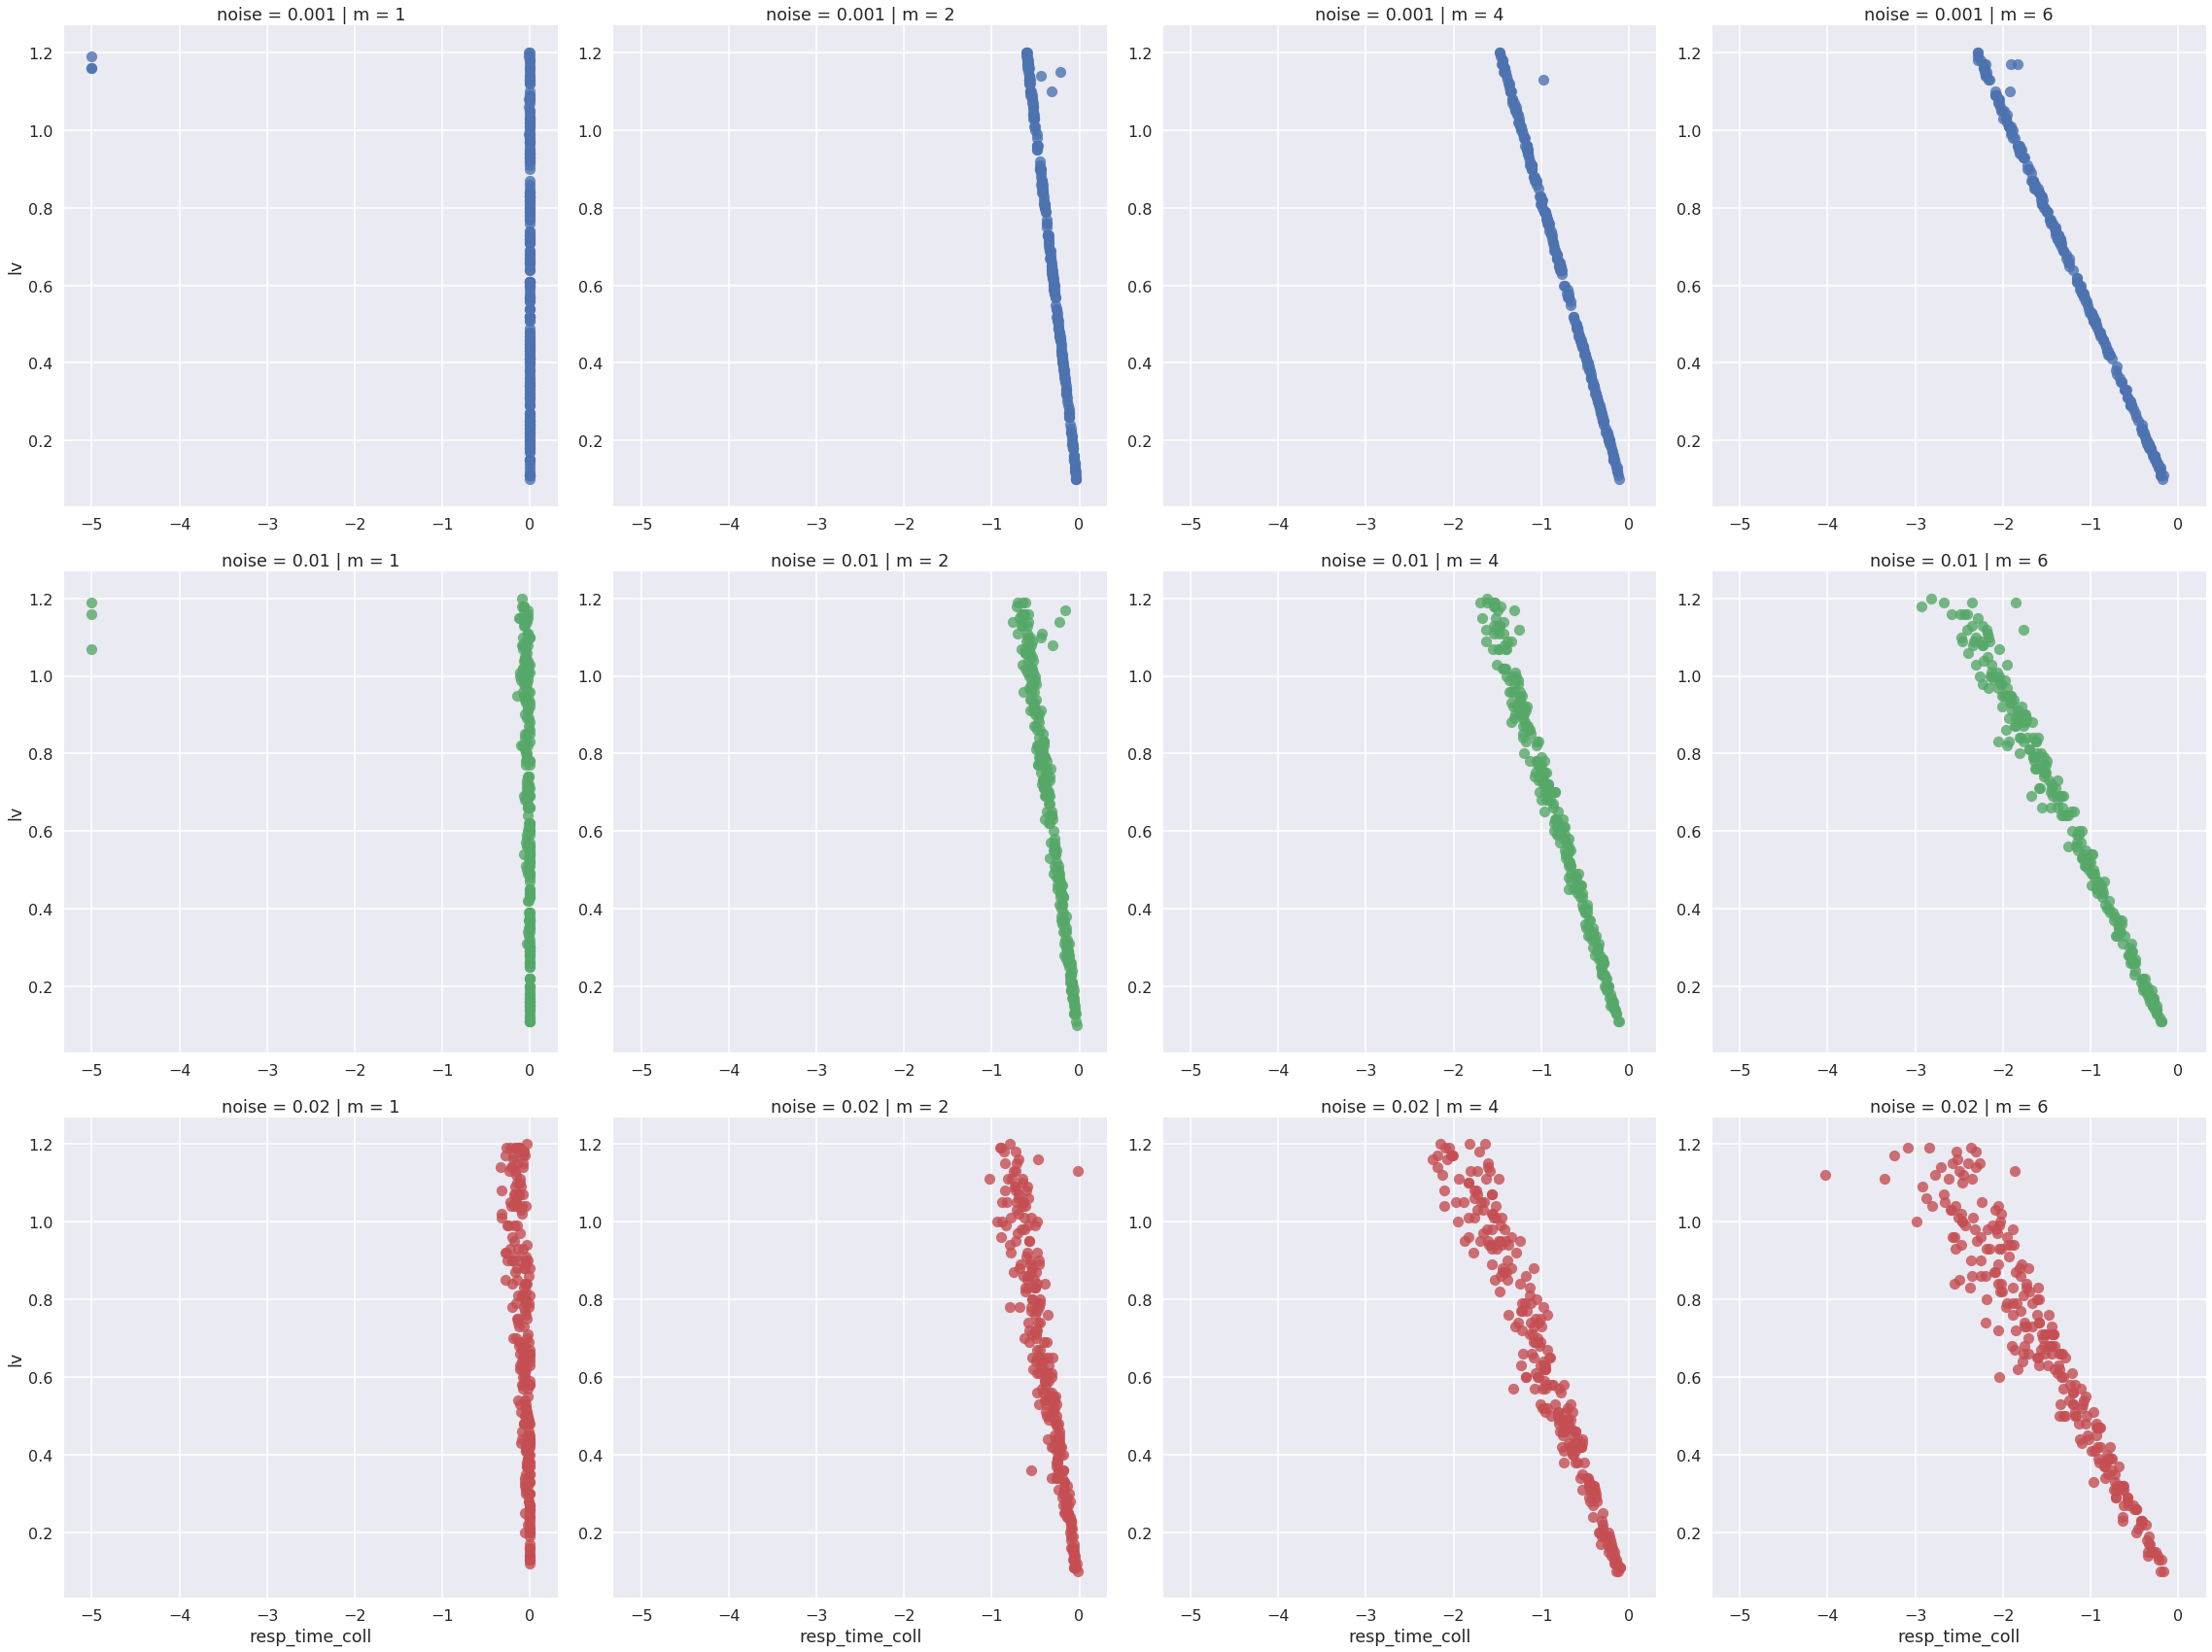

In [108]:
g = sns.lmplot(x='resp_time_coll', y='lv', hue='noise', row='noise', col='m', data=df, fit_reg=False, size=8)
g.savefig('rand_init_lv_vs_resp_time_coll_b=5.pdf')